In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [314]:
import covdict
import json
import numpy as np
import os
import pandas as pd 
import time
from IPython.html import widgets
from helper.plots import smoothfit
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import scale

## Helper functions for loading and processing data (from Nick Sofroniew)

In [3]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index, inplace = True)
    table.columns = table.columns.astype('float')
    return table

In [8]:
def load(session):
    
    with open(os.path.join(path, session, 'info.json')) as infile:
        info = json.load(infile)
        
    d = {}

    # Load the units, whih have our primary keys
    d['units'] = pd.DataFrame.from_csv(os.path.join(path, session, 'tables', 'units.csv'))
    
    # Load tables   
    d['tuning'] = pd.DataFrame.from_csv(os.path.join(path, session, 'tables', 'tuning.csv'))   
    d['tuning'] = align(d['tuning'], d['units'], ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarize(d['tuning'])
  
    d['units'].set_index('sourceId',inplace = True)

    # Add tables
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['dimensions'] = str(info['dimensions'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    return d, info

In [6]:
smooth = 1

def summarize(df):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0], smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[-1] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    summary['Modulation'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    summary['TotalModulation'] = (summary.Max - summary.Min)/(summary.Max + summary.Min)
    
    return summary

## Load data and summarize info

In [160]:
path = '/Users/fannjiangc/data/paper.tuning/'
session = 13 # animal ID

data = load('%02g' % session)
table = data[0]
info = data[1]
hz = info['rate-hz'][0] # sampling frequency

#### Metadata

In [161]:
info

,animal,animal-state,contributors,date,depth-microns,dimensions,experiment,id,indicator,lab,location,method,pixels-per-micron,rate-hz,region,session
Anm_0216166,Mouse,Awake head-fixed,Nicholas Sofroniew,2013_07_17,200,"[512, 512, 0]",Tactile Virtual Reality,Anm_0216166,GCaMP6s,Svoboda Lab,Janelia Research Campus,Two-photon raster,1.15,7.1,vS1,13


In [162]:
units = table.units.reset_index()
n_units = units.count()['sourceId'] # number of total neurons

## Identify tuned and active neurons

#### Fractions of tuned and active neurons

In [163]:
tuned = units.pVal < 0.05
active = units.unitMean > 0.75
summary = pd.DataFrame([sum((~active) & (~tuned)), sum(tuned), sum(active & (~tuned))], 
                               index=['inactive','tuned','untuned'], columns=['number'])
summary['frac'] = 100 * summary.number / summary.number.sum()
print summary

          number       frac
inactive     174  47.671233
tuned        163  44.657534
untuned       28   7.671233


#### Keep only significantly tuned neurons

In [164]:
table = table[tuned.values]

In [166]:
with open(os.path.join(path, session, 'params', 'covariates.json')) as infile:
    covariates = json.load(infile)
covariates = pd.DataFrame([x['value'] for x in covariates], index=[str(x['name']) for x in covariates]).T

In [167]:
timeseries = pd.DataFrame.from_csv(os.path.join(path, session, 'sources', 'timeseries.csv'))

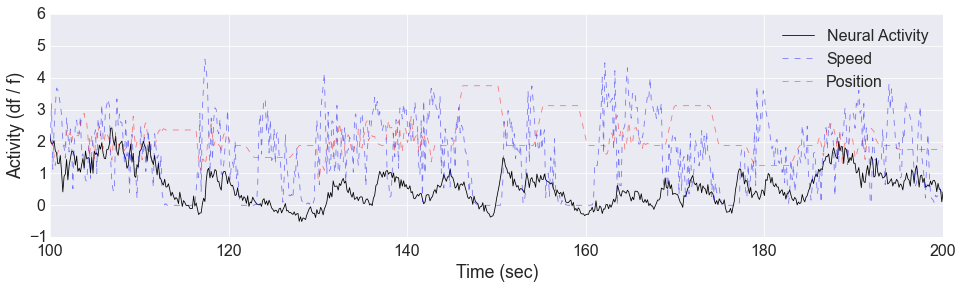

In [168]:
n = sum(active) # number of active neurons
ts = np.array(timeseries.loc[active, :])
n_samp = ts.shape[1] # number of samples

start = 100
stop = 200

def disp(s):
    sns.set_style('darkgrid')
    plt.figure(figsize=(16, 4));
    x = np.arange(n_samp) / hz
    plt.plot(x, ts[s, :], c='k', linewidth=0.8);
    plt.xlabel('Time (sec)');
    plt.ylabel('Activity (df / f)');
    
    plt.plot(x, covariates.speed / 16, '--b', alpha=0.5, linewidth=0.8);
    plt.plot(x, covariates.corPos / 8, '--r', alpha=0.5, linewidth=0.8);
    plt.xlim(start, stop);
    plt.ylim(-1, 6);
    plt.legend(['Neural Activity', 'Speed', 'Position']);
    
widgets.interact(disp, s = (0, n - 1, 1));

In [360]:
win = int(7 * hz) # window size = seconds x sampling rate in Hz
shift = 0.2

# Sample covariance per time window
X = np.vstack([np.cov(ts[:, i : i + win])[np.triu_indices(n)] for i in np.arange(0, n_samp - win, shift * win)]).T
n_win = X.shape[1]

In [364]:
reg_names = ['speed', 'corPos']
reg_idx = [np.where(name == covariates.keys())[0][0] for name in reg_names]
n_reg = len(reg_names)
regressors = np.vstack([np.mean(covariates.loc[i : i + win, :], axis=0) 
                        for i in np.arange(0, n_samp - win, shift * win)])
reg = regressors[:, reg_idx]

In [345]:
k = 3 # number of dictionary elements
reload(covdict)
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_gamma=0.5)
t = time.time()
Wadmm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.986524.
Iter: 100. Objective: 0.757577.
Iter: 180. Objective: 0.748969.
3.34124302864 seconds


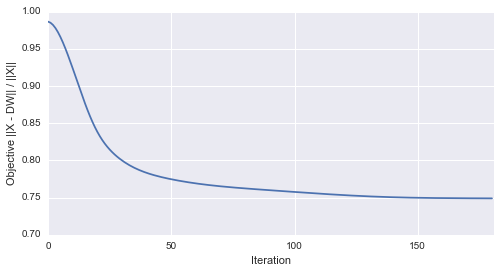

In [346]:
# Plot objective at each iteration and final learned weights.
sns.set_style('darkgrid')
plt.figure(figsize=(8, 4));

plt.plot(admm.objective);
plt.xlim(0, admm.objective.size);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

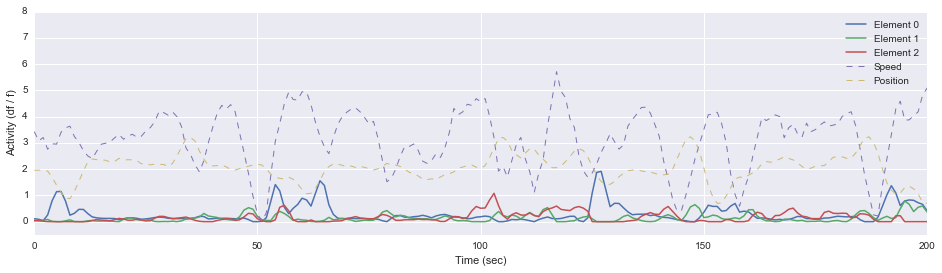

In [361]:
n = sum(active) # number of active neurons
ts = np.array(timeseries.loc[active, :])
n_samp = ts.shape[1] # number of samples

view = 200

def disp(start):
    
    sns.set_style('darkgrid')
    plt.figure(figsize=(16, 4));
    
    plt.plot(Wadmm.T, linewidth=1.5);
    plt.plot(reg / 8, '--', linewidth=1);    
    plt.xlabel('Time (sec)');
    plt.ylabel('Activity (df / f)');
    plt.xlim(start, start + view);
    plt.ylim(-0.5, 8);
    plt.legend(['Element ' + str(i) for i in range(k)] + ['Speed', 'Position']);
    
widgets.interact(disp, start = (0, n_win - view, view / 10));

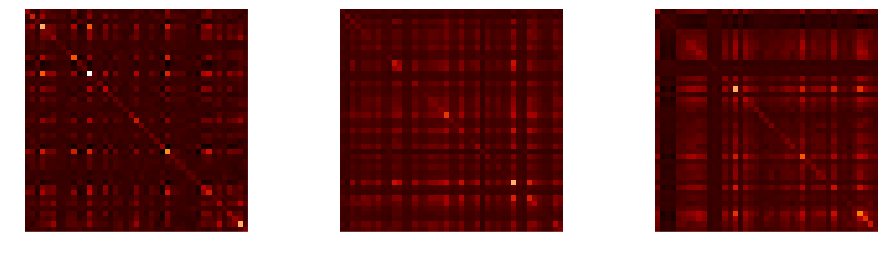

In [363]:
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

vmin = np.min(admm.dictionary)
vmax = np.max(admm.dictionary)

# Bilateral covariance is clearly pulled out
for i in range(k):
    plt.subplot(1, k, i + 1)   
    c = covdict.reform(admm.dictionary[:, i], n)
    plt.imshow(c, interpolation='None', cmap='gist_heat', vmin=vmin, vmax=vmax);
    plt.axis('off');

In [369]:
lr = LR(fit_intercept=True, normalize=False).fit(scale(reg, axis=0), Wadmm.T)
coef = lr.coef_
icp = lr.intercept_

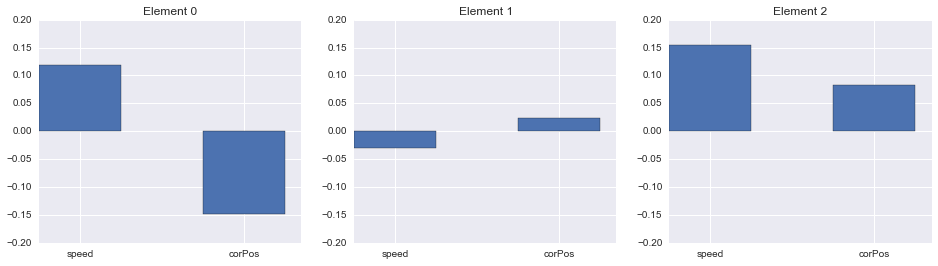

In [377]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(8 * n_reg, 4));

for i in range(k):
    ax = fig.add_subplot(1, k, i + 1);
    plt.title('Element ' + str(i));
    plt.bar(np.arange(n_reg), coef[i, :], width=0.5);
    ax.set_xticks(np.arange(n_reg) + width / 2);
    ax.set_xticklabels(reg_names);
    plt.ylim(-0.2, 0.2);